<a href="https://colab.research.google.com/github/Stitaprajna/AllMyProjects/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [238]:
df = pd.read_csv('/Fraud.csv', nrows=5*10**5)
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


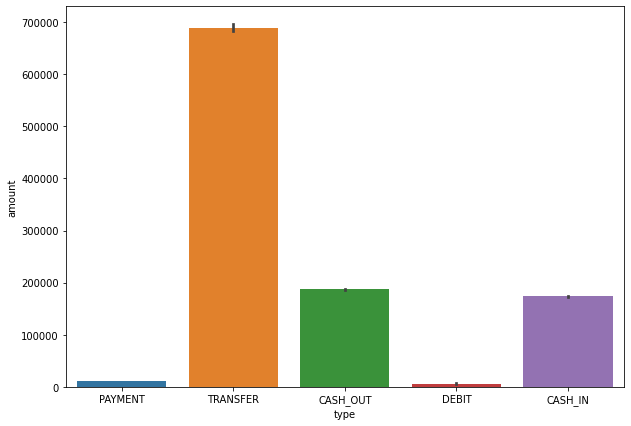

In [239]:
sns.barplot(x = 'type', y = 'amount', data=df)
plt.show()

So, most likely the 'Transfer' contains the fraud transactions.

In [240]:
df.isnull().sum()     # Checking for any missing data

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [241]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [242]:
df = df.dropna()      # Droping all NaN values

In [243]:
df.amount.describe()  # Describes various Statistical factors

count    5.000000e+05
mean     1.663937e+05
std      2.725841e+05
min      1.000000e-01
25%      1.335032e+04
50%      8.137560e+04
75%      2.226441e+05
max      1.000000e+07
Name: amount, dtype: float64

In [244]:
df = df[df['amount'] !=0]

# Detecting Outliers through visualisations

In the above scatter plot we can see that some of the data point are away from other data points. Thus, these points are the anomaly and most likely these are the 'Fraud' transactions. But, we can't say much from such a plot and will need a deep analysis.

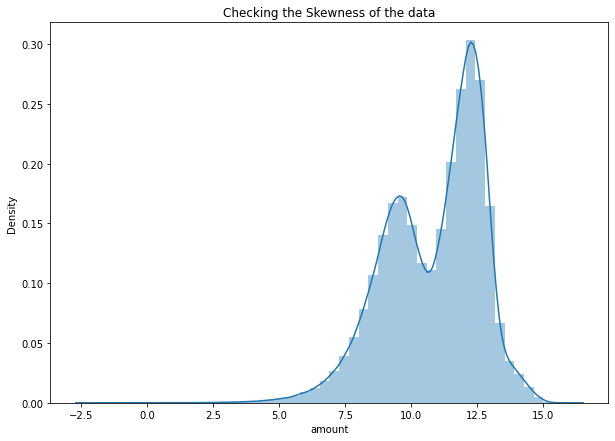

In [245]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
p = sns.distplot(np.log(df['amount'])).set(title='Checking the Skewness of the data')  # Highly Right Skewed Data
#plt.ylim([0,10**(-8)])
#plt.xlim(0,3*10**7)
plt.rcParams['figure.figsize'] = [10,10]

The tail of the amount of transaction distribuation is towards right, so this might be a 'Right Skewed Gaussian Data'. Lets find out at the skewness.

In [246]:
from scipy.stats import skew
skew(df.amount)

5.184748096392745

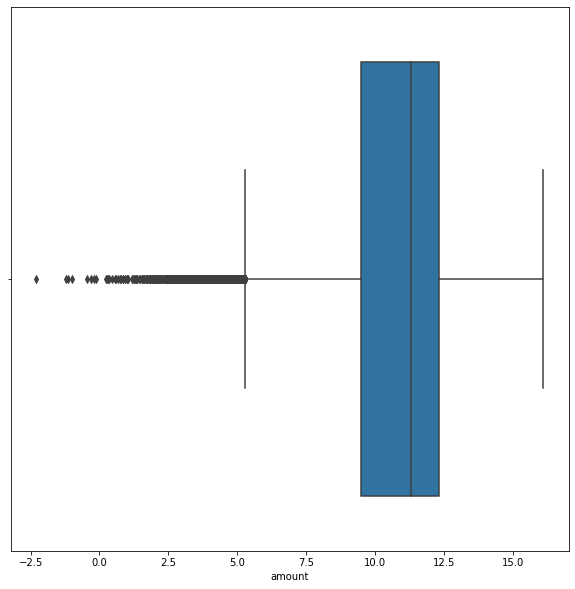

In [247]:
sns.boxplot(np.log(df.amount))
plt.show()
plt.rcParams['figure.figsize'] = [6,6]

In [248]:
df['isFraud'].value_counts()

0    499767
1       233
Name: isFraud, dtype: int64

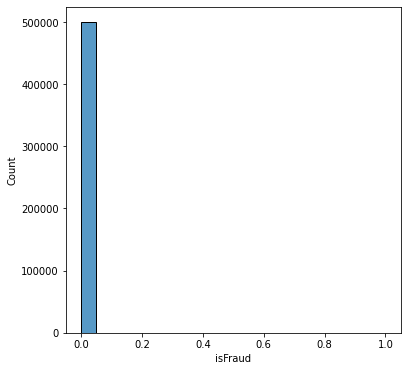

In [249]:
sns.histplot(df['isFraud'])

As, the number of fraud transactions are very less as compared to the normal transactions, this is an **Imbalanced Class**. Thus, accuracy score of any model will be very high and comapreble to the '**Dummy Classifier**'.

In [250]:
# Preprocessing and Cleaning Process

Fraud = df[df['isFraud'] == 1]    
Normal = df[df['isFraud']==0]
df1 = df.copy()
df1 = pd.get_dummies(df1,columns=['type'])
df2 = df1.copy()
df2.drop(['nameOrig','nameDest'],axis=1,inplace=True)
x = df2.drop(['isFraud','isFlaggedFraud','oldbalanceOrg','newbalanceOrig','newbalanceDest','oldbalanceDest'],axis=1)
x[['amount']] = x[['amount']].apply(lambda x: np.log(x))
y = df2.isFraud

# Statistical measures of the Fraud  & Normal transactions

In [251]:
Fraud.amount.describe()

count    2.330000e+02
mean     8.329005e+05
std      1.668775e+06
min      1.190000e+02
25%      2.012800e+04
50%      1.430320e+05
75%      9.944532e+05
max      1.000000e+07
Name: amount, dtype: float64

In [252]:
Normal.amount.describe()

count    4.997670e+05
mean     1.660830e+05
std      2.698829e+05
min      1.000000e-01
25%      1.334702e+04
50%      8.135710e+04
75%      2.225769e+05
max      6.419835e+06
Name: amount, dtype: float64

# Checking the amounts for Fraud vs Normal transations

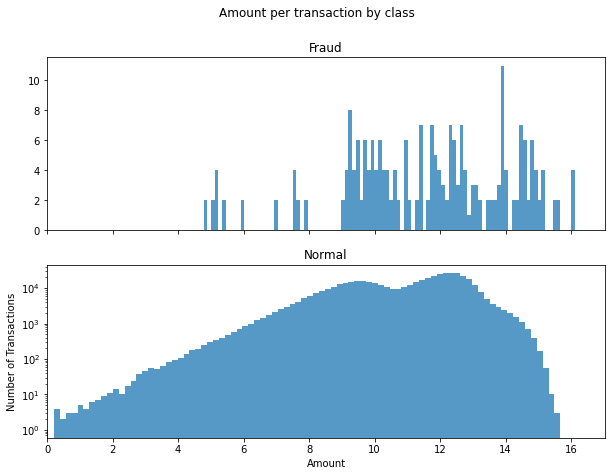

In [288]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True) 
f.suptitle('Amount per transaction by class')
bins = 100
ax1.hist(np.log(Fraud.amount), bins = bins,alpha=0.75)
ax1.set_title('Fraud')
ax2.hist(np.log(Normal.amount), bins = bins,alpha=0.75)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.rcParams['figure.figsize'] = [10, 7]
#plt.grid(True)
#ax1.grid(True)
plt.xlim([0,None])
plt.show()

The above plot compares the amount of 'Normal' vs 'Fraud' transactions. This shows fraudalent transactions are less in counts, but still have statistical significance.

# Model Selection Process

So, as we can see that this dataset contains Categorical as well as Numeric data, it will be good to use a 
**'Descision Tree Classifier'**. But, we have many optimised versions of the 'Descision Tree Classifier', we will use them one by one any evalute the best model upon the performance metrics.

In [254]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [255]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)           # Diving the dataset into training and testing dataset

In [256]:
y_test.value_counts()

0    149939
1        61
Name: isFraud, dtype: int64

In [257]:
outlier_fraction = len(Fraud)/len(Normal)

In [258]:
Isf = IsolationForest(contamination=outlier_fraction, max_samples=len(x_train), verbose=0, n_estimators=100)
loc = LocalOutlierFactor(contamination=outlier_fraction)
svm = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
xg = XGBClassifier()
Ada = AdaBoostClassifier()

In [259]:
y_prec = loc.fit_predict(x_test)
Isf.fit(x_train,y_train)
y_pred = Isf.predict(x_test)
svm.fit(x_train,y_train)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


# Choosing the right evaluation Metrics

We have to choose a different evaluation matrics other than the '**Accuracy**'. This is because, in an imbalanced dataset, the **'Accuracy Score'** might not be meaningfull or might not help in specific instances. For, this particular instance, we would like
to detect the 'Fraudlent' transactions, by keeping in mind that no '**Normal**' transaction is refered as '**Fraudlent**'. Also, no '**Fraudlent**' transaction should be refered as '**Noraml**'. These are also called the '**Type-I Error** and  '**Type-II Error** in statistics.
         

  # Prescision, Recall & Area Under Curve (AUC)
  '**Precesion**' and '**Recall**' are the evaluation metrics very usefull for specific purposes. '**Precesion**' is the ratio of '**True Positive**' and the sum of both '**True** **Positive**' and '**False** **Positive**'. Here, the '**True Positive**' is **Fraud Detection**. Similarly, in 'Recall' instead of '**False Positive**' it is '**False Negetive**'. Now, by keeping a '**Descision Thersold**', we will get different values of the both. And, if we plot them, we get a curve also known as the '**ROC**'. The area under this curve is important, because it's a measure of the desirable values of the both 'Precesion' and 'Recall'. This is also called the **Area Under Curve (AUC)**. 

# Choosing the best model w.r.t the AUC score

In [260]:
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,precision_score, confusion_matrix,recall_score

In [261]:
# Local Outlier Factor
y_prec[y_prec == 1] = 0
y_prec[y_prec == -1] = 1   

In [262]:
y_presvm = svm.predict(x_test)  # SVM 
recall_score(y_test,y_presvm)

0.0

Model: SVM


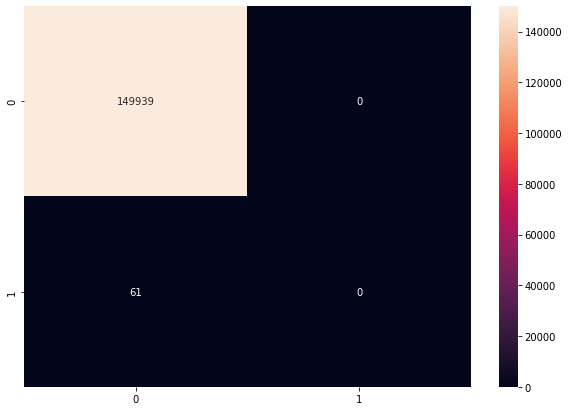

In [263]:
print('Model: SVM')

cm11 = confusion_matrix(y_test,y_presvm)
sns.heatmap(cm11,annot=True,fmt='d')
plt.show()

Predicted Fraud: 0/61

In [264]:
precision_score(y_test,y_pred)    # Isolation Forestb

0.0875

Model: Isolation Forest


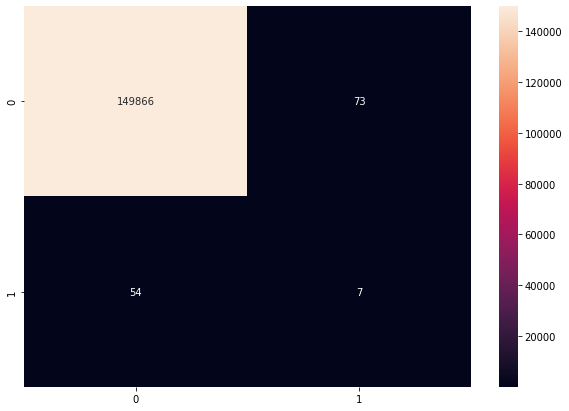

In [265]:
print('Model: Isolation Forest')
cm1 = confusion_matrix(y_test,y_pred)
sns.heatmap(cm1,annot=True, fmt='d')
plt.show()

Predicted Fraud: 7/61

In [266]:
precision_score(y_test, y_prec)   # Local Outlier Factor

0.17142857142857143

Model: Local outlier Factor


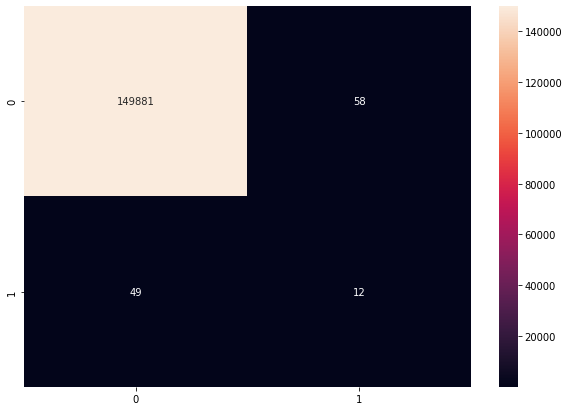

In [267]:
print('Model: Local outlier Factor')
cm1 = confusion_matrix(y_test,y_prec)
sns.heatmap(cm1,annot=True, fmt='d')
plt.show()

Predicted Fraud: 12/61

In [268]:
rf.fit(x_train,y_train)         # Random Forest
y_prerf = rf.predict(x_test)

In [269]:
# Random Forest 
precision_score(y_test,y_prerf)   

0.2647058823529412

Model: Random Forest


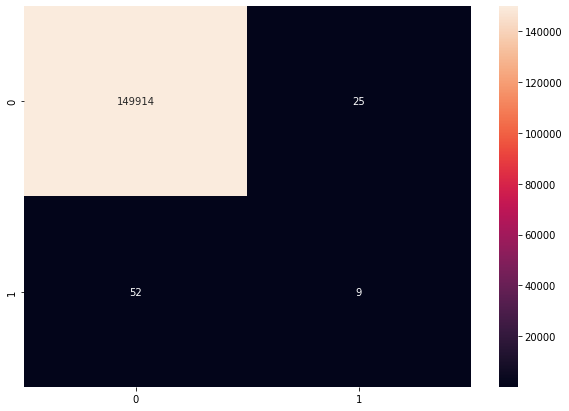

In [270]:
print('Model: Random Forest')
cm1 = confusion_matrix(y_test,y_prerf)
sns.heatmap(cm1,annot=True, fmt='d')
plt.show()

Predicted Fraud: 9/61

In [271]:
gb.fit(x_train,y_train)         # Gradiant Boost
y_pregb = gb.predict(x_test)    

In [272]:
precision_score(y_test,y_pregb)    # gradiant Boost  

0.38095238095238093

Model: Gradiant Boost


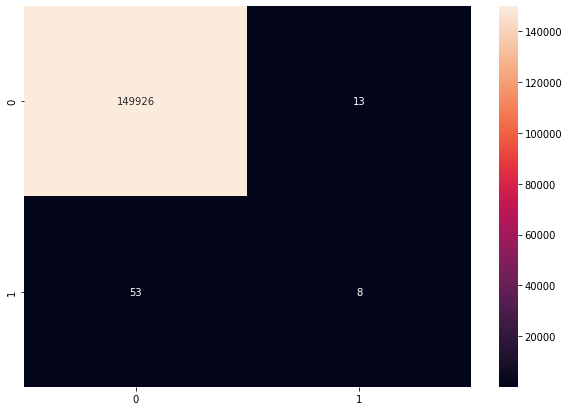

In [273]:
print('Model: Gradiant Boost')
cm1 = confusion_matrix(y_test,y_pregb)
sns.heatmap(cm1,annot=True, fmt='d')
plt.show()

Predicted Fraud: 8/61

In [274]:
xg.fit(x_train,y_train)          # Xg Boost
y_prexg = xg.predict(x_test)

In [275]:
recall_score(y_test,y_prexg)    # Xg Boost (2nd Best Score)

0.04918032786885246

Model: Xg Boost


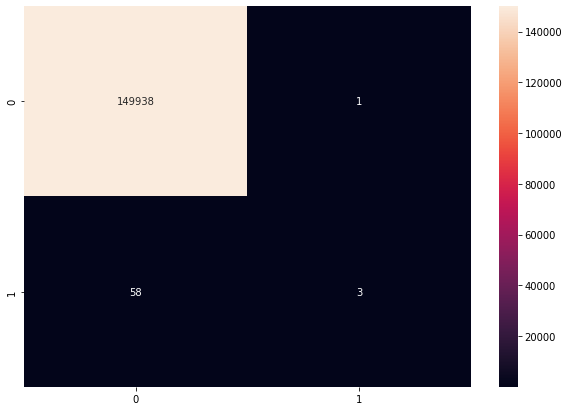

In [276]:
print('Model: Xg Boost')
cm6 = confusion_matrix(y_test,y_prexg)
sns.heatmap(cm6,annot=True, fmt='d')
plt.show()

 Predicted Fraud: 3/61

In [277]:
Ada.fit(x_train,y_train)          # Ada Boost
y_preaba = Ada.predict(x_test)

In [278]:
precision_score(y_test,y_preaba)    # Ada Boost (3rd Best Score)

0.6

Model: Ada Boost


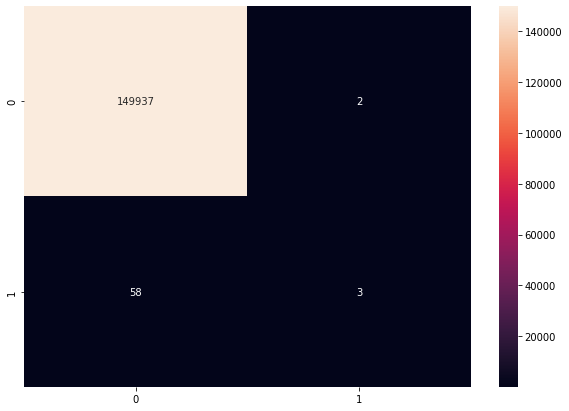

In [279]:
print('Model: Ada Boost')
cm8 = confusion_matrix(y_test,y_preaba)
sns.heatmap(cm8,annot=True, fmt='d')
plt.show()

In [280]:
# Neural Networks
from tensorflow import keras

model1 = keras.Sequential([
    keras.layers.Dense(7, input_shape=(7,),activation='relu'),
    keras.layers.Dense(1,activation='tanh')])
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model1.fit(x_train, y_train, epochs=5)

Epoch 1/5
10938/10938 [==============================] - 20s 2ms/step - loss: 0.0076 - accuracy: 0.9995
Epoch 2/5
10938/10938 [==============================] - 20s 2ms/step - loss: 0.0076 - accuracy: 0.9995
Epoch 3/5
10938/10938 [==============================] - 20s 2ms/step - loss: 0.0076 - accuracy: 0.9995
Epoch 4/5
10938/10938 [==============================] - 19s 2ms/step - loss: 0.0076 - accuracy: 0.9995
Epoch 5/5
10938/10938 [==============================] - 19s 2ms/step - loss: 0.0076 - accuracy: 0.9995


In [281]:
y_pn = model1.predict(x_test)

In [282]:
 y_prn = []
for i in y_pn:
  if i>=0:
    y_prn.append(1)  
  else:
    y_prn.append(0)

In [283]:
recall_score(y_test,y_prn)

0.0

Model: Neural Networks


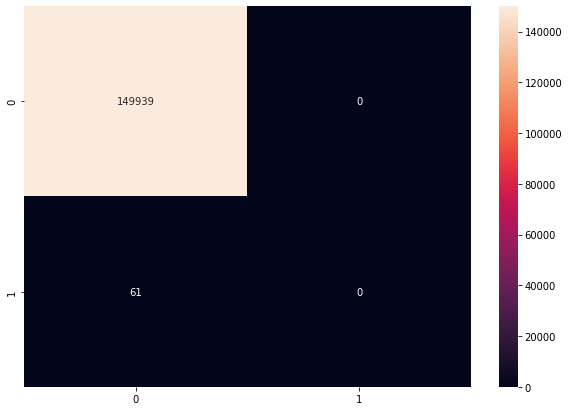

In [287]:
print('Model: Neural Networks')
cmm = confusion_matrix(y_test,y_prn)
sns.heatmap(cmm, annot=True, fmt='d')
plt.show()

Predicted Fraud: 0/61

In [285]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
499995,20,CASH_OUT,77616.32,C1125584113,402794.6,325178.28,C596605403,662541.78,410073.66,0,0
499996,20,CASH_OUT,63262.20,C1632642338,8500.0,0.00,C1989325178,0.00,63262.20,0,0
499997,20,PAYMENT,15019.29,C2105678886,5253.0,0.00,M171574465,0.00,0.00,0,0
499998,20,TRANSFER,355628.70,C1907483123,0.0,0.00,C1880058411,6533824.07,6889452.78,0,0


AS, we compared many ML classifiers to see which one will be best for the detection of the fraud. Although, the model accuracy score was very high for all the models, which is a clear sign of an **imbalaned class**. So, the names of the ML models according to their best **AUC scores** are:

(i)  Gradiant Boost

(ii)  Random Forest

(iii)  Xg Boost 

(iv) Ada Boost

(v) SVM

# Conclusions

Thus, we can use '**Gradiant Boost**' to detect the fraudalent transaction for this dataset. This model will ensure that maxmimum fraud transactions are detected, while keeping in mind that we are minimizing the declaration of a normal transtion as fradulant.

While updating the infrastructure, the company should protect its old data, like it should keep the 'features names' very secret on which the fraud detection is being made. If new features are being added, then a Principal Component Analysis (PCA) to make best choices. This should also be compared to the old model for chosing a better model. 

# Note

AS the dataset is very large and due to constrains of the Goggle Colab, a sample of the original data has been used for the model building and analysis. 